# Libraries

In [152]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# I added
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit
import re
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from textblob import TextBlob
import textstat
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np



# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

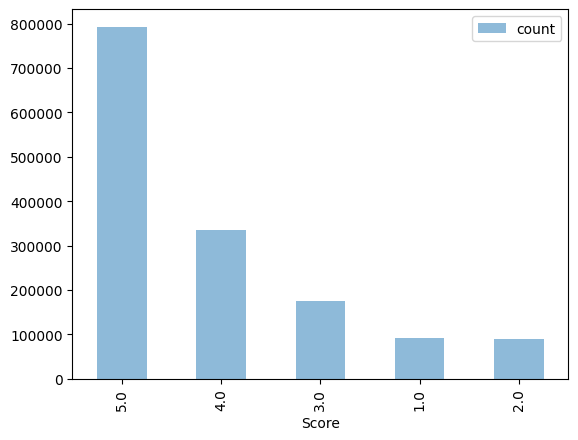


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/train.csv") 
testingSet = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Data Exploration

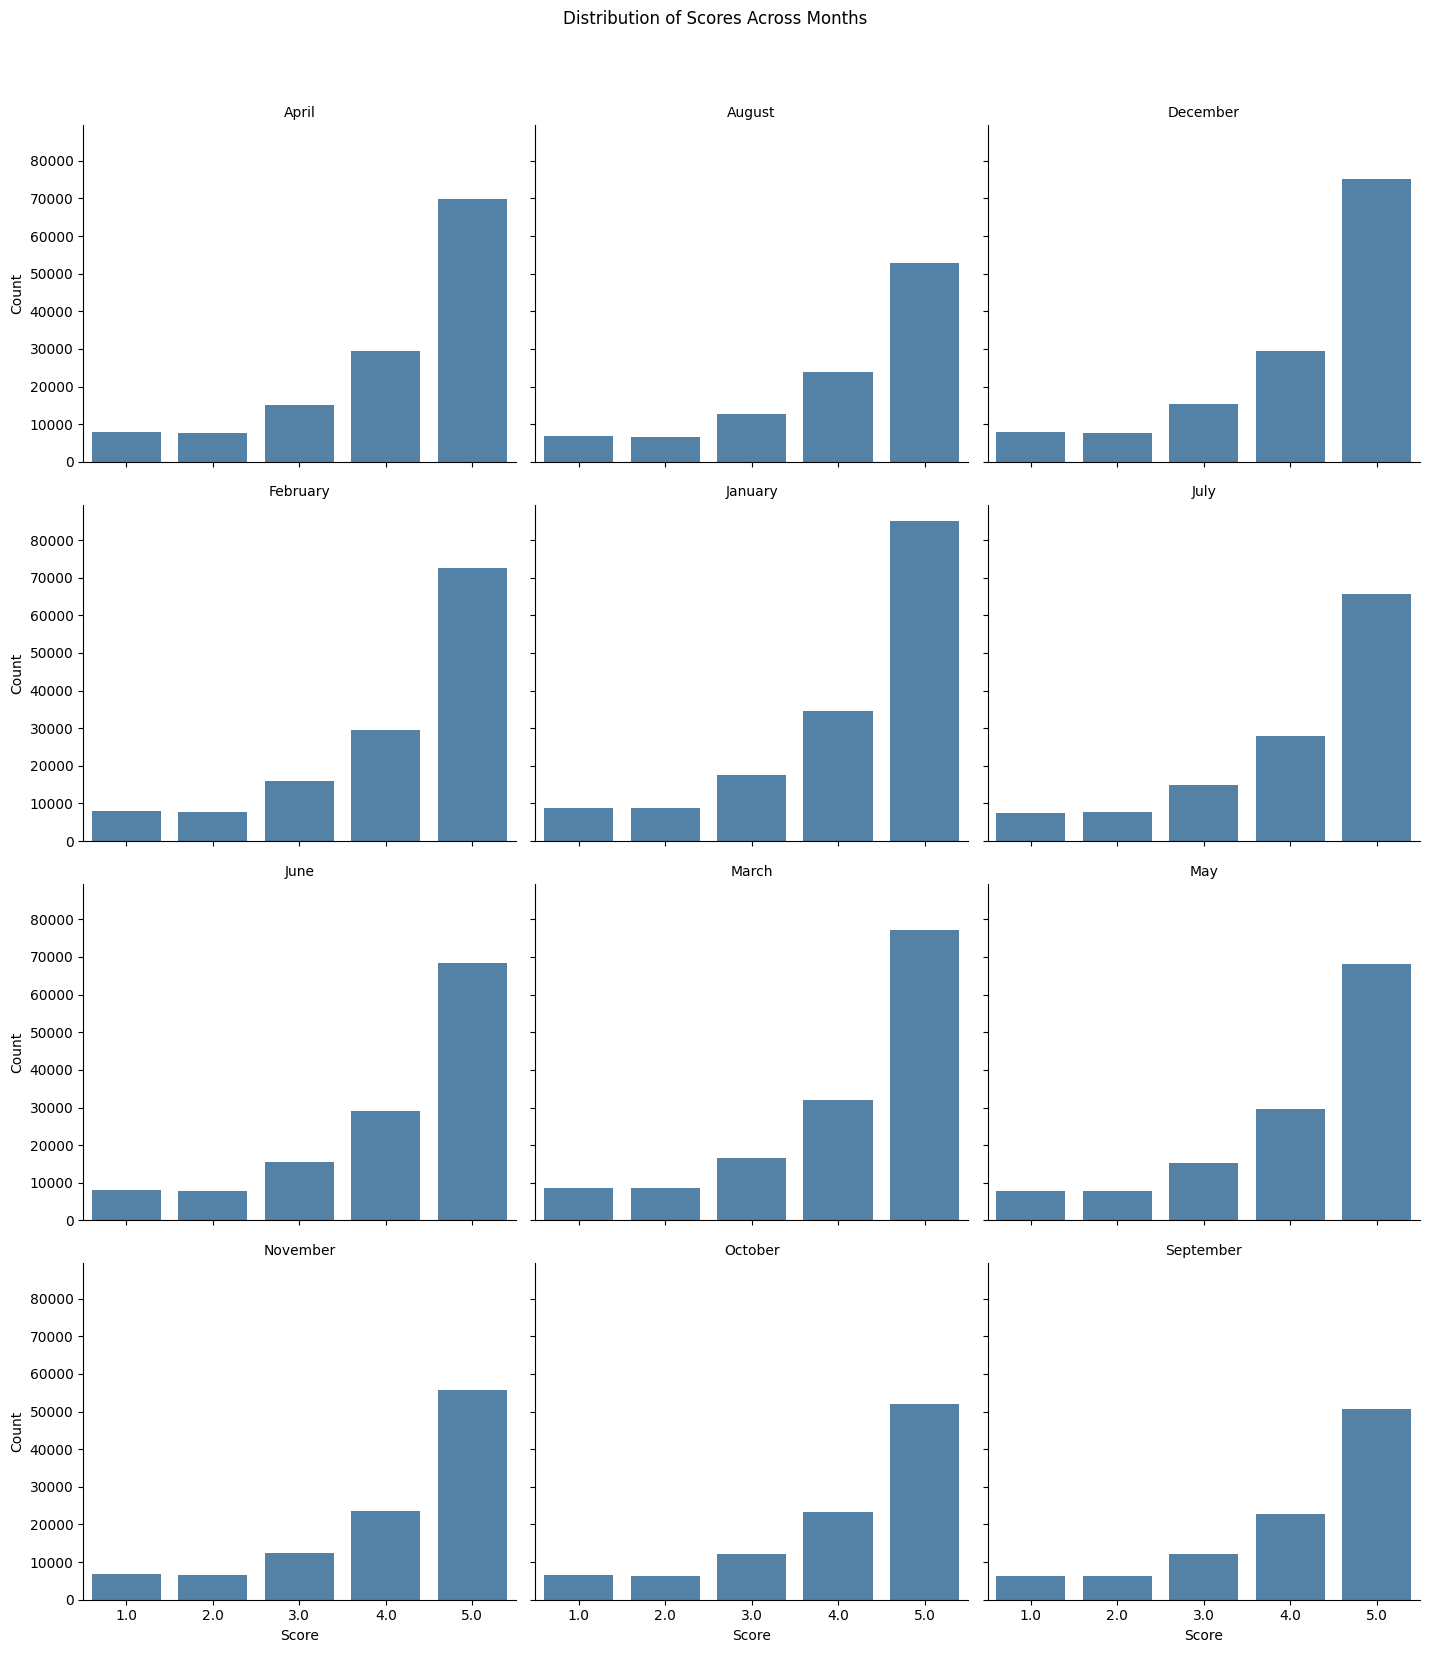

In [6]:
# Convert Unix timestamp to datetime and extract year and month
trainingSet['date'] = pd.to_datetime(trainingSet['Time'], unit='s')
trainingSet['month'] = trainingSet['date'].dt.strftime('%B')  # Full month name

# Group by month and score to count occurrences
df_count = trainingSet.groupby(['month', 'Score']).size().reset_index(name='count')

# Create a FacetGrid plot to facet by month
g = sns.FacetGrid(df_count, col='month', col_wrap=3, height=4, aspect=1.2)
g.map_dataframe(sns.barplot, x='Score', y='count', color='steelblue')

# Set the titles and labels
g.set_axis_labels("Score", "Count")
g.set_titles("{col_name}")
g.fig.suptitle('Distribution of Scores Across Months', y=1.03)

# Show the plot
plt.tight_layout()
plt.show()

# Adding Features

In [148]:


def add_sentiment_features(df):
    df['TextSentiment'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['SummarySentiment'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df


def add_readability_features(df):
    df['TextReadability'] = df['Text'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
    df['SummaryReadability'] = df['Summary'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
    return df


def add_topic_features(df, n_topics=5):
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    dtm = vectorizer.fit_transform(df['Text'].fillna(''))
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_matrix = lda.fit_transform(dtm)
    topic_df = pd.DataFrame(lda_matrix, columns=[f'Topic_{i+1}' for i in range(n_topics)])
    df = pd.concat([df.reset_index(drop=True), topic_df], axis=1)
    return df

def add_length_ratios(df):
    df['SummaryLengthRatio'] = df['SummaryLength'] / df['TextLength']
    df['HelpfulnessToLengthRatio'] = df['Helpfulness'] / (df['TextLength'] + 1)
    return df


def add_length_ratios(df):
    df['SummaryLengthRatio'] = df['SummaryLength'] / df['TextLength']
    df['HelpfulnessToLengthRatio'] = df['Helpfulness'] / (df['TextLength'] + 1)
    return df

def add_user_review_count(df):
    user_review_count = df.groupby('UserId')['UserId'].transform('count')
    df['UserReviewCount'] = user_review_count
    return df

def add_user_average_score(df):
    user_avg_score = df.groupby('UserId')['Score'].transform('mean')
    df['UserAverageScore'] = user_avg_score
    return df

def add_time_since_previous_review(df):
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values(by=['UserId', 'Time'])
    df['TimeSinceLastReview'] = df.groupby('UserId')['Time'].diff().dt.total_seconds().fillna(0)
    return df

def add_helpfulness_percentage(df):
    df['HelpfulnessPercentage'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    return df

def add_helpfulness_interaction(df):
    df['HelpfulnessInteraction'] = df['Helpfulness'] * df['Unhelpfulness']
    return df

def add_product_average_score(df):
    product_avg_score = df.groupby('ProductId')['Score'].transform('mean')
    df['ProductAverageScore'] = product_avg_score
    return df

def add_review_length_category(df):
    conditions = [
        (df['TextLength'] < 100), 
        (df['TextLength'] >= 100) & (df['TextLength'] < 500), 
        (df['TextLength'] >= 500)
    ]
    categories = ['short', 'medium', 'long']
    df['ReviewLengthCategory'] = np.select(conditions, categories)
    return df



In [153]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    # HELPFULNESS #############################
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0) # Helpfullness new feature

    df['Unhelpfulness'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
    df['Unhelpfulness'] = df['Unhelpfulness'].fillna(0) # Helpfullness new feature

    # SUMMARY #################################
    # Term Frequency Inverse Document Frequency 
    '''
    vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    tfidf_matrix = vectorizer.fit_transform(df['Summary'].fillna(''))  # Handling any NaN text entries
    summary_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df = pd.concat([df, summary_tfidf_df], axis=1)  # Concatenate TF-IDF features
    '''

    # Add a feature that calculates the character length of the summary
    df['SummaryLength'] = df['Summary'].fillna('').apply(len)

    # Add a feature that calculates the word count of the summary
    df['SummaryWordCount'] = df['Summary'].fillna('').apply(lambda x: len(x.split()))


    # TEXT ####################################
    # Term Frequency Inverse Document Frequency 
    '''
    vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    tfidf_matrix = vectorizer.fit_transform(df['Text'].fillna(''))  # Handling any NaN text entries
    text_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df = pd.concat([df, text_tfidf_df], axis=1)  # Concatenate TF-IDF features
    '''

    # Count all special characters (excluding alphanumeric and whitespace)
    df['SpecialCharCount'] = df['Text'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', str(x))))
        
    # Step 4: Add a feature to count question marks
    df['QuestionMarkCount'] = df['Text'].apply(lambda x: str(x).count('?'))
    
    # Step 5: Add a feature to count exclamation marks
    df['ExclamationMarkCount'] = df['Text'].apply(lambda x: str(x).count('!'))

    # Add a feature that calculates the character length of the summary
    df['TextLength'] = df['Text'].fillna('').apply(len)

    # Add a feature that calculates the word count of the summary
    df['TextWordCount'] = df['Text'].fillna('').apply(lambda x: len(x.split()))
   
    # TIME ####################################
    df['Month'] = pd.to_datetime(df['Time']).dt.month  # Extracts month from the 'Time' column
    

    # NEW #####################################
    df = add_sentiment_features(df)
    df = add_readability_features(df)
    df = add_topic_features(df)
    df = add_length_ratios(df)
    df = add_user_review_count(df)
    df = add_user_average_score(df)
    df = add_time_since_previous_review(df)
    df = add_helpfulness_percentage(df)
    df = add_helpfulness_interaction(df)
    df = add_product_average_score(df)
    df = add_review_length_category(df)
    
    return df


# Could look at user bias - is a specific person more likely to review poitiviely or negatively 
# How many emojis, how many exclamation marks 

    return df

# Load the feature extracted files if they've already been generated
if exists('/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv'):
    X_train = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv")
if exists('/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv'):
    X_submission = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv")

else:
    # Process the DataFrame
    # Step 1: Subset the training set (e.g., 10,000 rows of the data or a 10% of rows)
    # Use 'n' for a fixed number or use 'frac' to select a fraction of the data (10% in examply)
    subset_trainingSet = trainingSet.sample(n=10000, random_state=42) # Subset 10,000 rows of the data

    # Alternatively, you can subset 10% of data like this:
    # subset_trainingSet = trainingSet.sample(frac=0.1, random_state=42)
    

    # Step 2: Process the subsetted DataFrame with feature extraction
    train = add_features_to(subset_trainingSet)
    # train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv", index=False) # the data that will be used for final submission
    X_train.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv", index=False)

In [154]:
X_train.head()
print(X_train.describe())
column_names = X_train.columns.tolist()
print(column_names)

                 Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  8.747000e+03           8747.000000             8747.000000   
mean   8.457863e+05              3.242940                4.894592   
min    5.460000e+02              0.000000                0.000000   
25%    4.228530e+05              0.000000                0.000000   
50%    8.483730e+05              1.000000                1.000000   
75%    1.267711e+06              3.000000                4.000000   
max    1.697461e+06            283.000000              307.000000   
std    4.897326e+05             10.323726               12.708750   

                                Time        Score  Helpfulness  Unhelpfulness  \
count                           8747  8747.000000  8747.000000    8747.000000   
mean   1970-01-01 00:00:01.262047812     4.130788     0.402262       1.651652   
min    1970-01-01 00:00:00.910828800     1.000000     0.000000       0.000000   
25%    1970-01-01 00:00:01.162598400     4.000000     

# Sample + Split into training and testing set

In [157]:

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Can you add stratified CV here to help with the problem of unequal score distribution

# Feature Selection

In [161]:
'''
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', #'Time', 'Helpfulness', 
            # I added
            'Unhelpfulness', 'Month', #'SpecialCharCount', 'QuestionMarkCount', 'ExclamationMarkCount',
            #'SummaryLength', #'SummaryWordCount', #'TextLength', 'TextWordCount'
            ]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]
'''

# Define the numeric features and text columns
numeric_features = [
    'Helpfulness', 'Unhelpfulness', 'SummaryLength', 'SummaryWordCount', 
    'TextLength', 'TextWordCount', 'SpecialCharCount', 'QuestionMarkCount', 
    'ExclamationMarkCount', 'Month', 'HelpfulnessPercentage', 'HelpfulnessToLengthRatio',
    'SummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'TextReadability', 
    'SummaryReadability', 'UserReviewCount', 'UserAverageScore', 'TimeSinceLastReview', 
    'ProductAverageScore'
]

text_features = ['Summary', 'Text']

In [162]:
print("shape is ", X_train.shape)
print("shape is ", Y_train.shape)

shape is  (6560, 36)
shape is  (6560,)


# Model Creation

In [163]:
def build_knn_pipeline(selected_numeric_features, selected_text_features):
    """
    Build a KNN pipeline with dynamic feature selection.
    
    :param selected_numeric_features: List of numeric features to include
    :param selected_text_features: List of text features to include
    :return: Pipeline ready to be fit with data
    """
    # Numeric transformer (impute missing values and scale)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
        ('scaler', StandardScaler())  # Scale numeric features
    ])

    # Text transformer (TF-IDF vectorization and dimensionality reduction)
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),  # TF-IDF
        ('svd', TruncatedSVD(n_components=100))  # Dimensionality reduction (optional)
    ])

    # Define transformers for numeric and text features based on user input
    transformers = []
    
    # Add numeric features if selected
    if selected_numeric_features:
        transformers.append(('num', numeric_transformer, selected_numeric_features))
    
    # Add text transformers for each selected text feature (e.g., Summary, Text)
    for text_feature in selected_text_features:
        transformers.append((f'text_{text_feature}', text_transformer, text_feature))
    
    # Combine numeric and text transformers using ColumnTransformer
    preprocessor = ColumnTransformer(transformers=transformers)

    # Create the final pipeline with preprocessor and KNeighborsClassifier
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocessing
        ('knn', KNeighborsClassifier(n_neighbors=20))  # KNN classifier
    ])
    
    return model

# Build the model with selected features
model = build_knn_pipeline(numeric_features, text_features)

# Fit the model with the preprocessed training data
model.fit(X_train, Y_train)

# Learn the model
# model = KNeighborsClassifier(n_neighbors=20).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test)

# Model Evaluation

Accuracy on testing set =  0.8353909465020576


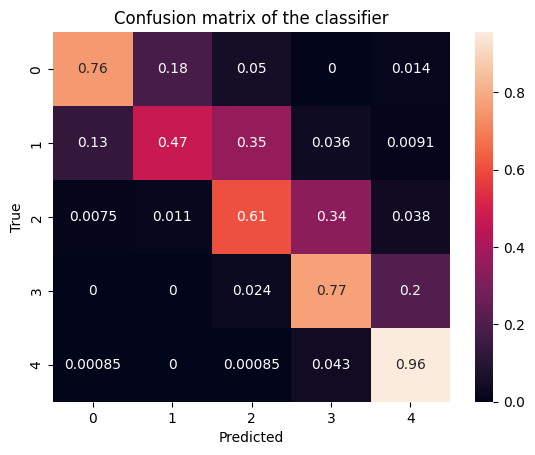

In [164]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prof thinking that 70% accuracy is good

# Create submission file

In [10]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/submission.csv", index=False)